In [ ]:
import tensorflow as tf
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is available


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
sns.set(style="dark")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DOL/Project1/

/content/drive/MyDrive/DOL/Project1


# Data Preprocessing


In [ ]:
# !git clone https://github.com/sevgicansalih/nwdaf_data

In [ ]:
data = pd.read_csv('nwdaf_data/nwdaf_data.csv')
data = data.drop(columns='has_anomaly')

In [ ]:
data.tail()

,t,cell_id,cat_id,pe_id,load
1295995,17279,4,2,0,2.984396
1295996,17279,4,2,1,19.591826
1295997,17279,4,2,2,90.086700
1295998,17279,4,2,3,1.006407
1295999,17279,4,2,4,6.020185


In [ ]:
cell0 = data.loc[data['cell_id']==0]
cell1 = data.loc[data['cell_id']==1]
cell2 = data.loc[data['cell_id']==2]
cell3 = data.loc[data['cell_id']==3]
cell4 = data.loc[data['cell_id']==4]

In [ ]:
load_cell0 = cell0.groupby('t')['load'].sum()
load_cell1 = cell1.groupby('t')['load'].sum()
load_cell2 = cell2.groupby('t')['load'].sum()
load_cell3 = cell3.groupby('t')['load'].sum()
load_cell4 = cell4.groupby('t')['load'].sum()

In [ ]:
week = 4*24*7

In [ ]:
load_cells = data.groupby('t')['load'].sum()

Text(0, 0.5, 'Load of \n all cells (Gbps)')

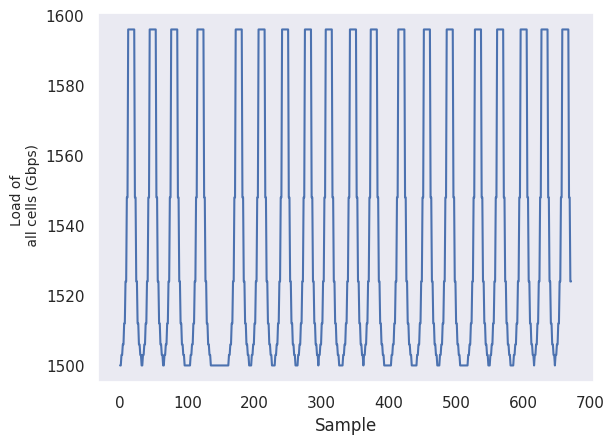

In [ ]:
plt.plot(load_cells[:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n all cells (Gbps)", fontsize=10)

# Centralized Training

In [ ]:
load_cells = load_cells.to_numpy().reshape(-1, 1)

scaler = MinMaxScaler()
scaled_load_cells =  scaler.fit_transform(load_cells)


## Train_test_split

In [ ]:
look_back = 2*week
def df_to_X_y(df, look_back=5):
  # df_as_np = df.to_numpy()
  df_as_np = df
  X = []
  y = []
  for i in range(len(df_as_np)-look_back):
    row = [[a] for a in df_as_np[i:i+look_back]]
    X.append(row)
    label = df_as_np[i+look_back]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
x, y = df_to_X_y(scaled_load_cells, look_back)

In [ ]:
x = x.reshape(x.shape[0],x.shape[1],x.shape[2])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [ ]:
n_epoch = 20
n_batch = 64
loss_function = MeanSquaredError()

lr=0.001
optimizer = Adam(learning_rate=lr)
validation_split = 0.2
verbosity = 2

In [ ]:
Centralized_model = Sequential()
Centralized_model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
Centralized_model.add(LSTM(units = 50, return_sequences = True))
Centralized_model.add(LSTM(units = 50, return_sequences = True))
Centralized_model.add(LSTM(units = 50))
Centralized_model.add(Dropout(0.3))
Centralized_model.add(Dense(units = 8, activation = 'relu'))
Centralized_model.add(Dropout(0.2))
Centralized_model.add(Dense(units = 1, activation = 'linear'))
Centralized_model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])
Centralized_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1344, 50)          10400     
                                                                 
 lstm_19 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_20 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_21 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 408       
                                                                 
 dropout_11 (Dropout)        (None, 8)                

In [ ]:
history_Centralized_model = Centralized_model.fit(x_train, y_train, epochs=n_epoch, batch_size=n_batch, shuffle=False, verbose= verbosity, validation_split= validation_split)

Epoch 1/20
160/160 - 38s - loss: 0.1005 - root_mean_squared_error: 0.3170 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1535 - 38s/epoch - 235ms/step
Epoch 2/20
160/160 - 25s - loss: 0.0346 - root_mean_squared_error: 0.1861 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893 - 25s/epoch - 154ms/step
Epoch 3/20
160/160 - 24s - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789 - 24s/epoch - 150ms/step
Epoch 4/20
160/160 - 25s - loss: 0.0201 - root_mean_squared_error: 0.1418 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763 - 25s/epoch - 155ms/step
Epoch 5/20
160/160 - 27s - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714 - 27s/epoch - 168ms/step
Epoch 6/20
160/160 - 25s - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623 - 25s/epoch - 154ms/step
Epoch 7/20
160/160 - 24s - loss: 0.0153 - root_mean_squared_erro

In [ ]:
train_predictions = Centralized_model.predict(x_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train.reshape(y_train.shape[0])})
train_results

,Train Predictions,Actuals
0,0.046521,3.125000e-02
1,0.038468,7.105427e-15
2,0.035592,7.105427e-15
3,0.036669,7.105427e-15
4,0.040050,7.105427e-15
...,...,...
12743,0.957186,1.000000e+00
12744,0.951630,1.000000e+00
12745,0.958133,1.000000e+00
12746,0.966910,1.000000e+00


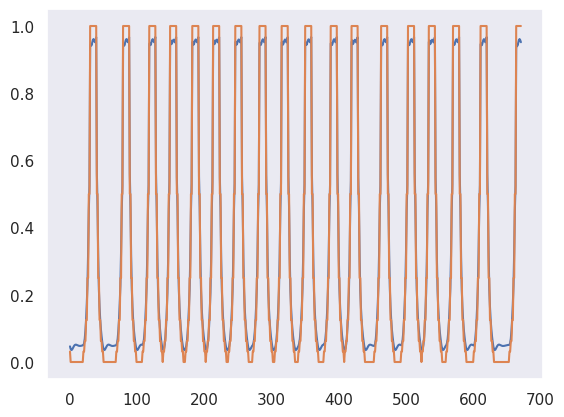

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:week])
plt.plot(train_results['Actuals'][:week])

In [ ]:
test_predictions = Centralized_model.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.reshape(y_test.shape[0])})
test_results

100/100 [==============================] - 7s 69ms/step


,Test Predictions,Actuals
0,0.460885,5.000000e-01
1,0.310956,2.500000e-01
2,0.214466,2.500000e-01
3,0.162040,1.250000e-01
4,0.124452,1.250000e-01
...,...,...
3183,0.047934,5.684342e-14
3184,0.050419,5.506706e-14
3185,0.051594,5.506706e-14
3186,0.051661,5.506706e-14


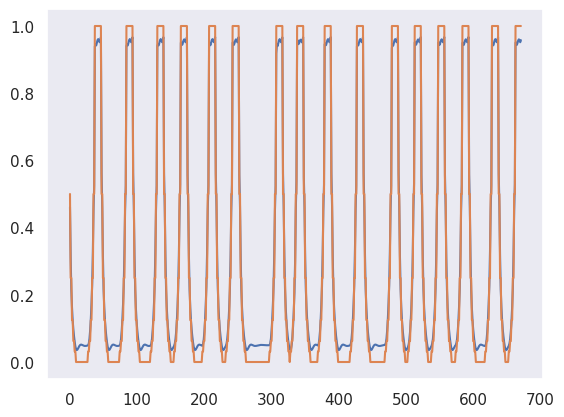

In [ ]:
plt.plot(test_results['Test Predictions'][:week])
plt.plot(test_results['Actuals'][:week])

In [ ]:
inv_pred_cells = scaler.inverse_transform(test_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cells = scaler.inverse_transform(test_results['Actuals'][:week].to_numpy().reshape(-1,1))

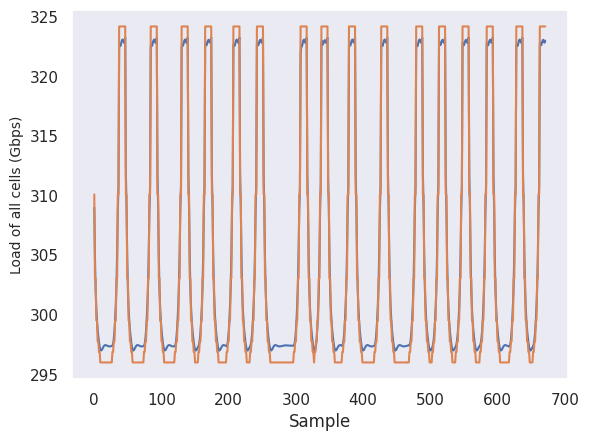

In [ ]:
plt.plot(inv_pred_cells)
plt.plot(inv_acc_cells)
plt.xlabel("Sample")
plt.ylabel("Load of all cells (Gbps)", fontsize=10);

In [ ]:
scaled_load_cell0 = scaler.fit_transform(load_cell0.to_numpy().reshape(-1, 1))
scaled_load_cell1 = scaler.fit_transform(load_cell1.to_numpy().reshape(-1, 1))
scaled_load_cell2 = scaler.fit_transform(load_cell2.to_numpy().reshape(-1, 1))
scaled_load_cell3 = scaler.fit_transform(load_cell3.to_numpy().reshape(-1, 1))
scaled_load_cell4 = scaler.fit_transform(load_cell4.to_numpy().reshape(-1, 1))

In [ ]:
x_cell0, y_cell0 = df_to_X_y(scaled_load_cell0, look_back)
x_cell1, y_cell1 = df_to_X_y(scaled_load_cell1, look_back)
x_cell2, y_cell2 = df_to_X_y(scaled_load_cell2, look_back)
x_cell3, y_cell3 = df_to_X_y(scaled_load_cell3, look_back)
x_cell4, y_cell4 = df_to_X_y(scaled_load_cell4, look_back)

In [ ]:
x_cell0 = x_cell0.reshape(x_cell0.shape[0],x_cell0.shape[1],x_cell0.shape[2])
x_cell1 = x_cell1.reshape(x_cell1.shape[0],x_cell1.shape[1],x_cell1.shape[2])
x_cell2 = x_cell2.reshape(x_cell2.shape[0],x_cell2.shape[1],x_cell2.shape[2])
x_cell3 = x_cell3.reshape(x_cell3.shape[0],x_cell3.shape[1],x_cell3.shape[2])
x_cell4 = x_cell4.reshape(x_cell4.shape[0],x_cell4.shape[1],x_cell4.shape[2])

In [ ]:
cell0_predictions = Centralized_model.predict(x_cell0).flatten()
cell0_results = pd.DataFrame(data={'Test Predictions':cell0_predictions, 'Actuals':y_cell0.reshape(y_cell0.shape[0])})

cell1_predictions = Centralized_model.predict(x_cell1).flatten()
cell1_results = pd.DataFrame(data={'Test Predictions':cell1_predictions, 'Actuals':y_cell1.reshape(y_cell1.shape[0])})

cell2_predictions = Centralized_model.predict(x_cell2).flatten()
cell2_results = pd.DataFrame(data={'Test Predictions':cell2_predictions, 'Actuals':y_cell2.reshape(y_cell2.shape[0])})

cell3_predictions = Centralized_model.predict(x_cell3).flatten()
cell3_results = pd.DataFrame(data={'Test Predictions':cell3_predictions, 'Actuals':y_cell3.reshape(y_cell3.shape[0])})

cell4_predictions = Centralized_model.predict(x_cell4).flatten()
cell4_results = pd.DataFrame(data={'Test Predictions':cell4_predictions, 'Actuals':y_cell4.reshape(y_cell4.shape[0])})


498/498 [==============================] - 33s 66ms/step


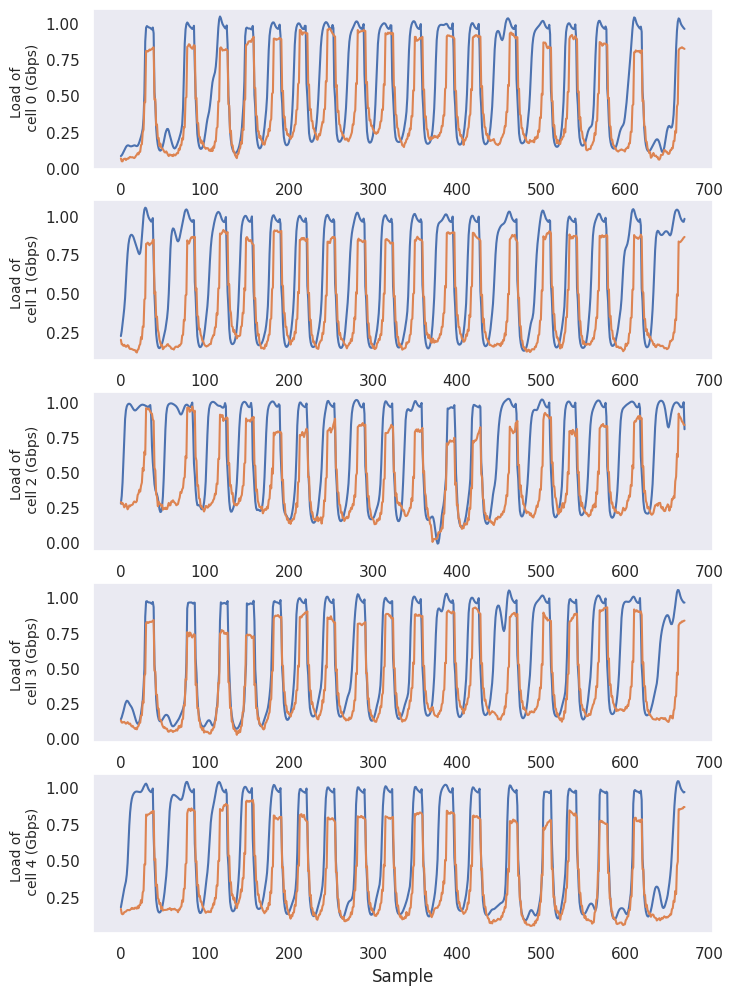

In [ ]:
week = 4*24*7
plt.figure(figsize=(8, 12))

plt.subplot(5, 1, 1)
plt.plot(cell0_results['Test Predictions'][:week])
plt.plot(cell0_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 0 (Gbps)", fontsize=10)

plt.subplot(5, 1, 2)
plt.plot(cell1_results['Test Predictions'][:week])
plt.plot(cell1_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 1 (Gbps)", fontsize=10)

plt.subplot(5, 1, 3)
plt.plot(cell2_results['Test Predictions'][:week])
plt.plot(cell2_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 2 (Gbps)", fontsize=10)

plt.subplot(5, 1, 4)
plt.plot(cell3_results['Test Predictions'][:week])
plt.plot(cell3_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 3 (Gbps)", fontsize=10)

plt.subplot(5, 1, 5)
plt.plot(cell4_results['Test Predictions'][:week])
plt.plot(cell4_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 4 (Gbps)", fontsize=10)
plt.show();

In [ ]:
inv_pred_cell0 = scaler.inverse_transform(cell0_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell0 = scaler.inverse_transform(cell0_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell1 = scaler.inverse_transform(cell1_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell1 = scaler.inverse_transform(cell1_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell2 = scaler.inverse_transform(cell2_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell2 = scaler.inverse_transform(cell2_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell3 = scaler.inverse_transform(cell3_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell3 = scaler.inverse_transform(cell3_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell4 = scaler.inverse_transform(cell4_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell4 = scaler.inverse_transform(cell4_results['Actuals'][:week].to_numpy().reshape(-1,1))

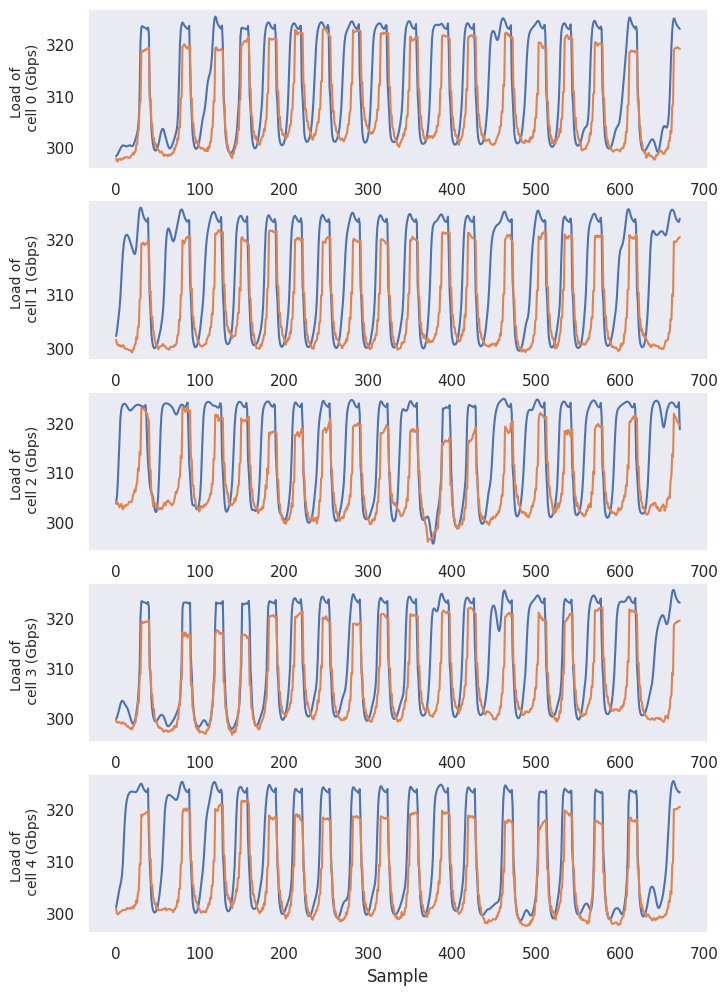

In [ ]:
week = 4*24*7
plt.figure(figsize=(8, 12))

plt.subplot(5, 1, 1)
plt.plot(inv_pred_cell0)
plt.plot(inv_acc_cell0)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 0 (Gbps)", fontsize=10)

plt.subplot(5, 1, 2)
plt.plot(inv_pred_cell1)
plt.plot(inv_acc_cell1)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 1 (Gbps)", fontsize=10)

plt.subplot(5, 1, 3)
plt.plot(inv_pred_cell2)
plt.plot(inv_acc_cell2)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 2 (Gbps)", fontsize=10)

plt.subplot(5, 1, 4)
plt.plot(inv_pred_cell3)
plt.plot(inv_acc_cell3)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 3 (Gbps)", fontsize=10)

plt.subplot(5, 1, 5)
plt.plot(inv_pred_cell4)
plt.plot(inv_acc_cell4)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 4 (Gbps)", fontsize=10)
plt.show();

In [ ]:
print("MSE for all cells: ", mean_squared_error(y_pred=inv_pred_cells, y_true=inv_acc_cells))
print("MSE for cell0: ", mean_squared_error(y_pred=inv_pred_cell0, y_true=inv_acc_cell0))
print("MSE for cell1: ", mean_squared_error(y_pred=inv_pred_cell1, y_true=inv_acc_cell1))
print("MSE for cell2: ", mean_squared_error(y_pred=inv_pred_cell2, y_true=inv_acc_cell2))
print("MSE for cell3: ", mean_squared_error(y_pred=inv_pred_cell3, y_true=inv_acc_cell3))
print("MSE for cell4: ", mean_squared_error(y_pred=inv_pred_cell4, y_true=inv_acc_cell4))

MSE for all cells:  1.3972772450920863
MSE for cell0:  72.72714167746727
MSE for cell1:  111.38922822627903
MSE for cell2:  116.59941957084469
MSE for cell3:  71.4557183732619
MSE for cell4:  63.81630502787491
